# **Facial Expression Recognition Competition (30%)**
For this competition, we will use the a facial classification dataset. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

We provide baseline code that includes the following features:

*   Loding and Analysing the FER-2013 dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following changes could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]


In [153]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Facial Expression Recognition/Classification
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

In [154]:
# Importing libraries.

import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [155]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# # Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
# data_directory ='/content/drive/MyDrive/Datasets/fer2013/fer2013.csv'

In [156]:
# Reading the dataset file using Pandas read_csv function and print the first
# 5 samples.
#
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
data_df = pd.read_csv("fer2013.csv")
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [157]:
# Mapping of the Facial Expression Labels.
Labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [158]:
# Categorizing the dataset to three categories.
# Training: To train the model.
# PrivateTest: To test the train model; commonly known as Validation.
# PublicTest: To test the final model on Test set to check how your model perfomed. Do not use this data as your validation data.
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PrivateTest']
test_df = data_df[data_df['Usage']=='PublicTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels        Usage
32298        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
32299        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
32300        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
32301        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
32302        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
...        ...                                                ...          ...
35881        0 

In [159]:
# Test-check to see wether usage labels have been allocated to the dataset/not.
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest


In [160]:
# Preview of the training sample and associated labels.
def show_example(df, num):
    row = df.iloc[num]
    emotion = Labels[row['emotion']]
    print('expression: ', emotion)
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  Fear
(1, 2304)


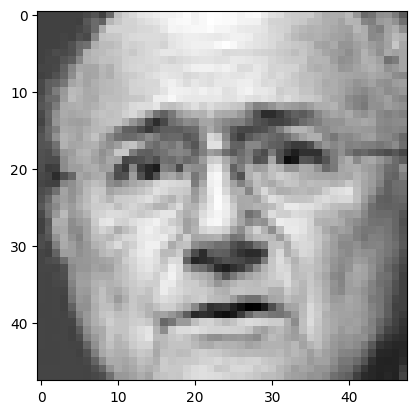

In [161]:
show_example(train_df, 5)

In [162]:
# Normalization of the train and validation data.
class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))


        if self.transforms:
            image = self.transforms(image)

        return image.clone().detach(), label

In [163]:
#import albumentations as A
stats = ([0.5],[0.5])

In [164]:
train_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True),
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)
])

In [165]:
train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


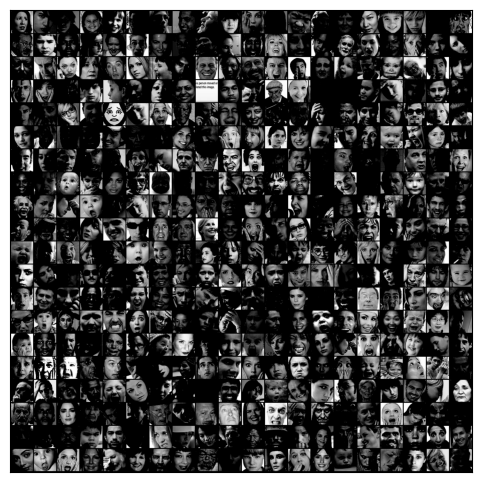

In [166]:
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

show_batch(train_dl)

In [167]:
# Evaluation metric - Accuracy in this case.

import torch.nn.functional as F
input_size = 48*48
output_size = len(Labels)

def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [168]:
# Expression model class for training and validation purpose.

class expression_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [169]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(f'You are training on: {device}.')

You are training on: cuda.


In [170]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [171]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [172]:
# Basic model - 1 layer
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [173]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([400, 1, 48, 48])
out.shape: torch.Size([400, 8, 24, 24])


In [174]:
# Model - 7 layer
class expression(expression_model):
    def __init__(self,classes):
        super().__init__()
        self.num_classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(),
            nn.Linear(256*6*6, 2304),
            nn.LeakyReLU(),
            nn.Linear(2304, 1152),
            nn.LeakyReLU(),
            nn.Linear(1152, 576),
            nn.LeakyReLU(),
            nn.Linear(576,288),
            nn.LeakyReLU(),
            nn.Linear(288,144),
            nn.LeakyReLU(),
            nn.Linear(144,self.num_classes))

    def forward(self, xb):
        return self.network(xb)

In [175]:
# Model print
model = to_device(expression(classes = 7), device)
model

expression(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

In [176]:
# Functions for evaluation and training.
@torch.no_grad()
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [177]:
evaluate(model, valid_dl)

{'val_loss': 1.9491451978683472, 'val_acc': 0.11694280058145523}

In [178]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [179]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch[0], val_loss: 1.7416, val_acc: 0.2698
Epoch[1], val_loss: 1.5125, val_acc: 0.3965
Epoch[2], val_loss: 1.4505, val_acc: 0.4291
Epoch[3], val_loss: 1.6969, val_acc: 0.3759
Epoch[4], val_loss: 1.1844, val_acc: 0.5437
Epoch[5], val_loss: 1.2776, val_acc: 0.5228
Epoch[6], val_loss: 1.1751, val_acc: 0.5604
Epoch[7], val_loss: 1.1044, val_acc: 0.5897
Epoch[8], val_loss: 1.1090, val_acc: 0.5929
Epoch[9], val_loss: 1.1138, val_acc: 0.5912


In [180]:
# Plots for accuracy and loss during training period.
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

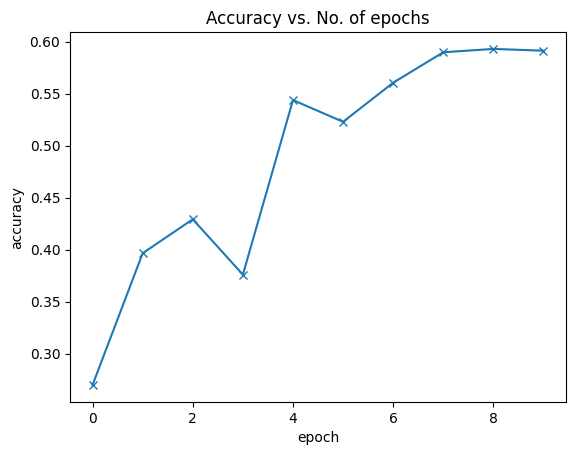

In [181]:
plot_accuracies(history)

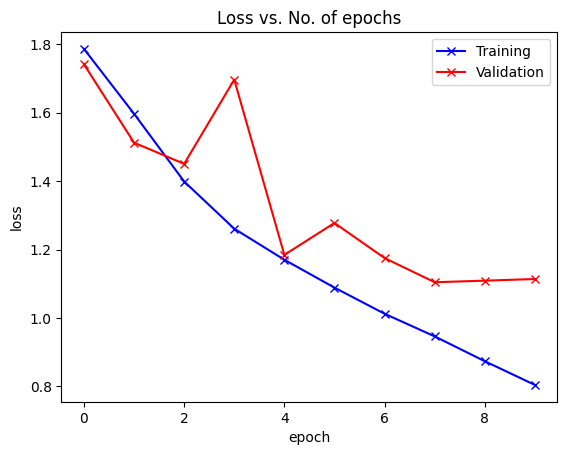

In [182]:
plot_losses(history)

In [183]:
# Model evaluation on test data.
result = evaluate(model, test_dl)
result

{'val_loss': 1.155440330505371, 'val_acc': 0.5813984870910645}

In [184]:
# Prediction function to evaluate the model.
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

Label: Angry , Predicted: Neutral


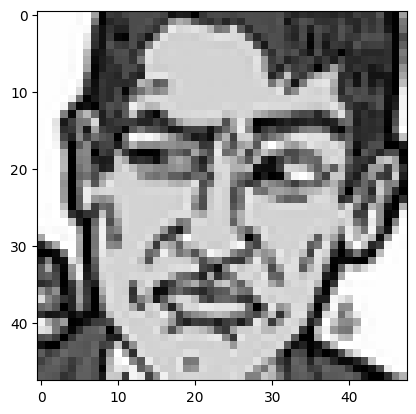

In [185]:
img, label = test_ds[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

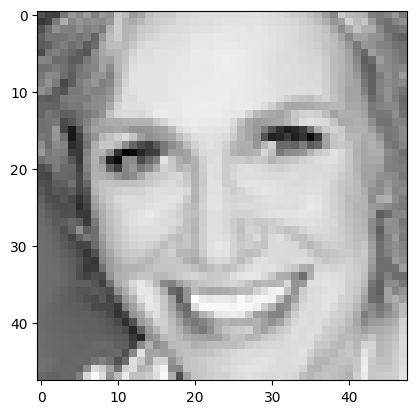

In [190]:
img, label = test_ds[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [187]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

Defaulting to user installation because normal site-packages is not writeable


In [188]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 7
model = expression(num_classes)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

Unsupported operator aten::add_ encountered 7 time(s)
Unsupported operator aten::leaky_relu encountered 12 time(s)
Unsupported operator aten::max_pool2d encountered 3 time(s)


FLOPs: 0.32981 GFLOPs
